# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [110]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 3

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [111]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
print(X_full.dtype)

torch.float32


In [112]:
x_arr=np.asarray(X_full)
y_arr=np.asarray(y_full)
x1=x_arr[:, 0]
x2=x_arr[:, 1]
x1_sq=x1**2
x2_sq=x2**2
xm=x1*x2
xs=x1*x1*x2
xt=x1*x2*x2
xu=x1**3+x2
xv=x1+x2**3
r=np.sqrt(x1**2+x2**2)

In [113]:
x_stacked=np.column_stack([x1,x2,x1_sq,x2_sq,xm,xs,xt,xu,xv,r])
x_train, x_test, y_train, y_test = train_test_split(x_stacked, y_arr, test_size=0.3, random_state=42)

In [114]:
x_train = torch.tensor(x_train,dtype=torch.float32)
x_test = torch.tensor(x_test,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test,dtype=torch.float32).view(-1, 1)

In [115]:
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = torch.clamp(y_pred, min=epsilon, max=1 - epsilon)
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

In [116]:
scaler = StandardScaler()
x_train = torch.tensor(scaler.fit_transform(x_train.numpy()),dtype=torch.float32)
x_test  = torch.tensor(scaler.transform(x_test.numpy()),dtype=torch.float32)

In [117]:
w1 = torch.randn(10, 16)*np.sqrt(4/10)
w1.requires_grad_()
b1 = torch.zeros(16, requires_grad=True)

w2 = torch.randn(16, 16)*np.sqrt(4/16)
w2.requires_grad_()
b2 = torch.zeros(16, requires_grad=True)

w3 = torch.randn(16, 16)*np.sqrt(4/16)
w3.requires_grad_()
b3 = torch.zeros(16, requires_grad=True)

w4 = torch.randn(16, 1)*np.sqrt(2/16)
w4.requires_grad_()
b4 = torch.zeros(1, requires_grad=True)
parameters = [w1, b1, w2, b2, w3, b3, w4, b4]


In [120]:
learning_rate = 0.01
epsilon = 1e-7
train_losses = []
val_losses = []
train_acc = []
val_acc = []

In [121]:
for epoch in range(600):
    z1 = torch.matmul(x_train, w1) + b1
    a1 = torch.relu(z1)
    z2 = torch.matmul(a1, w2) + b2
    a2 = torch.relu(z2)
    z3 = torch.matmul(a2, w3) + b3
    a3 = torch.relu(z3)
    z4 = torch.matmul(a3, w4) + b4
    a4 = torch.sigmoid(z4)

    bce_loss = -torch.mean(y_train*torch.log(a4+epsilon)+(1-y_train)*torch.log(1-a4+epsilon))
    train_losses.append(bce_loss.item())

    bce_loss.backward()

    # Applying Stochastic Gradient Descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        b1 -= learning_rate * b1.grad
        w2 -= learning_rate * w2.grad
        b2 -= learning_rate * b2.grad
        w3 -= learning_rate * w3.grad
        b3 -= learning_rate * b3.grad
        w4 -= learning_rate * w4.grad
        b4 -= learning_rate * b4.grad
        # Reset gradients to zero after updating.
        # Otherwise, PyTorch accumulates (adds) gradients in the next loop.
        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()
        w3.grad.zero_()
        b3.grad.zero_()
        w4.grad.zero_()
        b4.grad.zero_()
    train_accuracy = ((a4 >= 0.5) == y_train).float().mean().item()
    train_acc.append(train_accuracy)
    with torch.no_grad():
      a1v = torch.relu(torch.matmul(x_test, w1) + b1)
      a2v = torch.relu(torch.matmul(a1v, w2) + b2)
      a3v = torch.relu(torch.matmul(a2v, w3) + b3)
      a4v = torch.sigmoid(torch.matmul(a3v, w4) + b4)
      val_loss = -torch.mean(y_test * torch.log(a4v + epsilon)+(1 - y_test) * torch.log(1 - a4v + epsilon))
      val_losses.append(val_loss.item())

      val_accuracy = ((a4v >= 0.5) == y_test).float().mean().item()
      val_acc.append(val_accuracy)

    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | " f"Train Loss: {bce_loss.item():.4f} | " f"Val Loss: {val_loss.item():.4f} | " f"Train Acc: {train_accuracy:.4f} | " f"Val Acc: {val_accuracy:.4f}")


Epoch   0 | Train Loss: 0.4410 | Val Loss: 0.4202 | Train Acc: 0.8271 | Val Acc: 0.8344
Epoch  20 | Train Loss: 0.4350 | Val Loss: 0.4138 | Train Acc: 0.8333 | Val Acc: 0.8467
Epoch  40 | Train Loss: 0.4295 | Val Loss: 0.4078 | Train Acc: 0.8400 | Val Acc: 0.8489
Epoch  60 | Train Loss: 0.4243 | Val Loss: 0.4021 | Train Acc: 0.8424 | Val Acc: 0.8544
Epoch  80 | Train Loss: 0.4192 | Val Loss: 0.3967 | Train Acc: 0.8471 | Val Acc: 0.8622
Epoch 100 | Train Loss: 0.4144 | Val Loss: 0.3916 | Train Acc: 0.8524 | Val Acc: 0.8667
Epoch 120 | Train Loss: 0.4097 | Val Loss: 0.3865 | Train Acc: 0.8543 | Val Acc: 0.8667
Epoch 140 | Train Loss: 0.4051 | Val Loss: 0.3816 | Train Acc: 0.8586 | Val Acc: 0.8733
Epoch 160 | Train Loss: 0.4006 | Val Loss: 0.3769 | Train Acc: 0.8619 | Val Acc: 0.8811
Epoch 180 | Train Loss: 0.3963 | Val Loss: 0.3722 | Train Acc: 0.8676 | Val Acc: 0.8833
Epoch 200 | Train Loss: 0.3921 | Val Loss: 0.3677 | Train Acc: 0.8719 | Val Acc: 0.8900
Epoch 220 | Train Loss: 0.3880 |

In [122]:
with torch.no_grad():
    preds = (a4v >= 0.5)
    final_accuracy = (preds == y_test).float().mean().item()

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")


Final Test Accuracy: 0.9344


In [123]:
print(len(train_losses), len(val_losses))


600 600


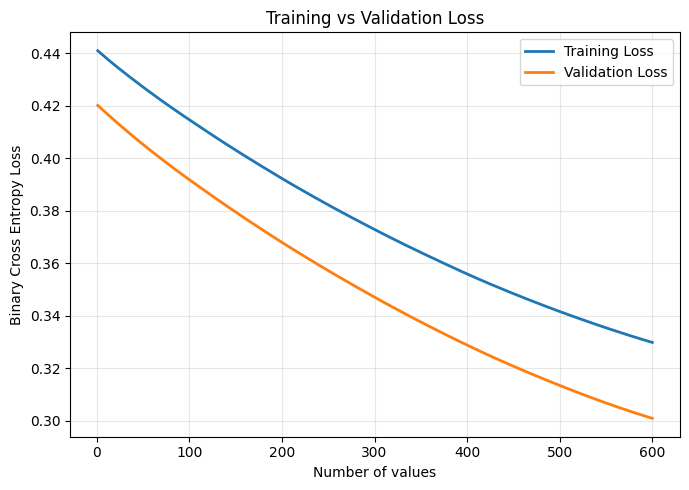

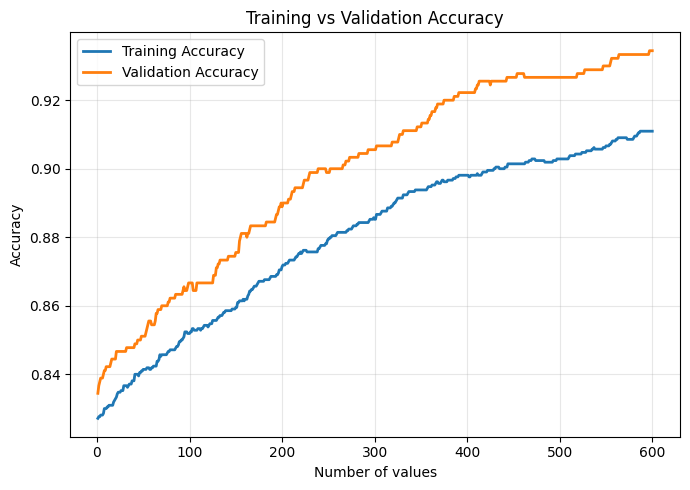

In [125]:
x = range(1, 601)

plt.figure(figsize=(7, 5))
plt.plot(x, train_losses, label="Training Loss", linewidth=2)
plt.plot(x, val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Number of values")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(x, train_acc, label="Training Accuracy", linewidth=2)
plt.plot(x, val_acc, label="Validation Accuracy", linewidth=2)
plt.xlabel("Number of values")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [126]:
x_val = x_arr[:, 0]
y_val = x_arr[:, 1]
x_min, x_max = x_val.min()-1, x_val.max()+1
y_min, y_max = y_val.min()-1, y_val.max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),np.linspace(y_min, y_max, 500))
x1g=xx.ravel()
x2g=yy.ravel()
x1g_sq=x1g**2
x2g_sq=x2g**2
xmg=x1g*x2g
xsg=x1g*x1g*x2g
xtg=x1g*x2g*x2g
xug=x1g**3+x2g
xvg=x1g+x2g**3
rg=np.sqrt(x1g**2+x2g**2)
X_grid=np.c_[x1g,x2g,x1g_sq,x2g_sq,xmg,xsg,xtg,xug,xvg,rg]
X_grid = scaler.transform(X_grid)
X_grid = torch.tensor(X_grid, dtype=torch.float32)
with torch.no_grad():
    h1 = torch.relu(X_grid @ w1 + b1)
    h2 = torch.relu(h1 @ w2 + b2)
    h3 = torch.relu(h2 @ w3 + b3)
    probs = torch.sigmoid(h3 @ w4 + b4)

Z = probs.cpu().numpy().reshape(xx.shape)

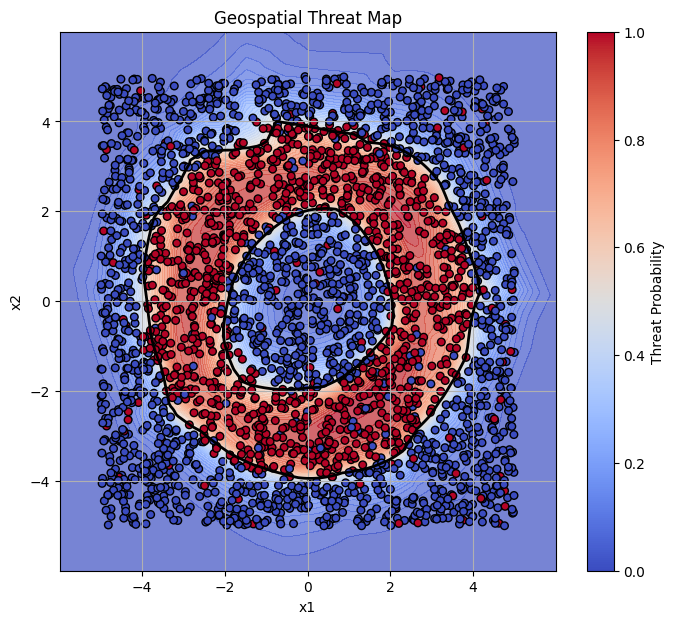

In [127]:
plt.figure(figsize=(8, 7))
plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.7)
plt.contour(xx, yy, Z, levels=[0.5], colors="black", linewidths=2)
plt.scatter(
    x_arr[:, 0], x_arr[:, 1],
    c=y_arr, cmap="coolwarm",
    edgecolors="k", s=30
)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Geospatial Threat Map")
plt.colorbar(label="Threat Probability")
plt.grid(True)
plt.show()